In [283]:
import pygeostat as gs
from sdcalc import *
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [284]:
data = gs.DataFile('data/walker.dat', x='Xlocation in meter', y='Ylocation in meter')

In [285]:
sdcalc(data, 'Xlocation in meter', 'Ylocation in meter', None, 'T variable, indicator variable')

calculating signed distances for rock type 1
calculating signed distances for rock type 2


In [286]:
data.head()

,Identification Number,Xlocation in meter,Ylocation in meter,"V variable, concentration in ppm","U variable, concentration in ppm","T variable, indicator variable",signed_distances_rt_1,signed_distances_rt_2
0,1.0,11.0,8.0,0.0,NaN,2.0,168.433963,-168.433963
1,2.0,8.0,30.0,0.0,NaN,2.0,161.743624,-161.743624
2,3.0,9.0,48.0,224.4,NaN,2.0,145.890370,-145.890370
3,4.0,8.0,69.0,434.4,NaN,2.0,129.468143,-129.468143
4,5.0,9.0,90.0,412.1,NaN,2.0,113.137085,-113.137085


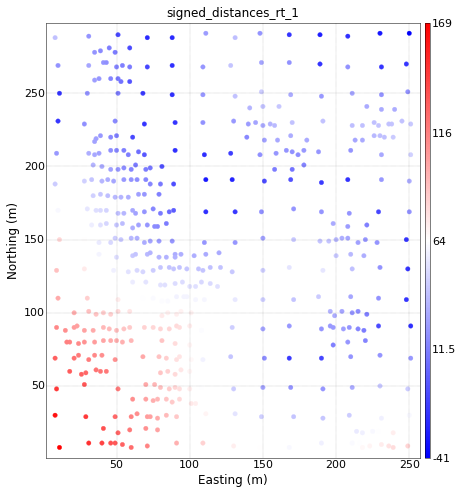

In [287]:
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr', grid=True)

In [288]:
grid = data.infergriddef(blksize=((1,1,0)))

In [289]:
grid

Pygeostat GridDef:
253 3.5 1.0 
293 3.5 1.0 
1 0.5 1.0

In [290]:
grid_coords = grid.get_coordinates()
data_coords = (data[data.x].values, data[data.y].values, np.ones(len(data))*0.5)

In [291]:
class RBF_PoU:
    def __init__(self, data_coords, grid_coords, D, nmax):
        self.D = D
        self.nmax = nmax
        self.data_coords = data_coords
        self.xp, self.yp, self.zp = self.data_coords[0], self.data_coords[1], self.data_coords[2]
        self.grid_coords = grid_coords
        self.xg, self.yg, self.zg = self.grid_coords[0], self.grid_coords[1], self.grid_coords[2]

        self.used = []
        self.pts_idx_list = []
        self.grid_idx_list = []
        self.centers = []
        self.lower = []
        self.upper = []
        self.ul_partitions = [np.arange(len(self.xp))]

    def split(self, pidxs, idx):
        
        xp, yp, zp = self.xp[pidxs], self.yp[pidxs], self.zp[pidxs]
        
        n = len(xp)
        print('Number of samples in Pc: {}'.format(n))
        if n > self.nmax:
            self.used.append(False)
            nn = int(np.ceil(n/2*(1+self.D)))
            print('Number of samples in Pl and Pu: {}'.format(nn))
            del self.ul_partitions[idx]
        
            deltax, deltay, deltaz = np.max(xp)-np.min(xp), np.max(yp)-np.min(yp), np.max(zp)-np.min(zp)
            longaxis = np.argmax([deltax, deltay, deltaz])
            sortedindices = np.argsort([xp, yp, zp][longaxis])

            pidx1, pidx2 = sortedindices[:nn], sortedindices[n-nn:]
            self.pts_idx_list.append(pidx1)
            self.pts_idx_list.append(pidx2)
            
            self.ul_partitions.append(pidx1)
            self.ul_partitions.append(pidx2)
            
            minx1, maxx1 = np.min(xp[pidx1]), np.max(xp[pidx1])
            minx2, maxx2 = np.min(xp[pidx2]), np.max(xp[pidx2])

            miny1, maxy1 = np.min(yp[pidx1]), np.max(yp[pidx1])
            miny2, maxy2 = np.min(yp[pidx2]), np.max(yp[pidx2])

            minz1, maxz1 = np.min(zp[pidx1]), np.max(zp[pidx1])
            minz2, maxz2 = np.min(zp[pidx2]), np.max(zp[pidx2])

            cx1, cy1, cz1 = (minx1-maxx1)/2, (miny1-maxy1)/2, (minz1-maxz1)/2
            cx2, cy2, cz2 = (minx2-maxx2)/2, (miny2-maxy2)/2, (minz2-maxz2)/2
            self.centers.append([cx1, cy1, cz1])
            self.centers.append([cx2, cy2, cz2])
            self.lower.append([minx1, miny1, minz1])
            self.upper.append([maxx1, maxy1, maxz1])
            self.lower.append([minx2, miny2, minz2])
            self.upper.append([maxx2, maxy2, maxz2])

            fx1 = np.logical_and(self.xg >= minx1, self.xg <= maxx1)
            fy1 = np.logical_and(self.yg >= miny1, self.yg <= maxy1)
            fz1 = np.logical_and(self.zg >= minz1, self.zg <= maxz1)
            f1g = np.logical_and.reduce([fx1, fy1, fz1])
            self.grid_idx_list.append(f1g)

            fx2 = np.logical_and(self.xg >= minx2, self.xg <= maxx2)
            fy2 = np.logical_and(self.yg >= miny2, self.yg <= maxy2)
            fz2 = np.logical_and(self.zg >= minz2, self.zg <= maxz2)
            f2g = np.logical_and.reduce([fx2, fy2, fz2])
            self.grid_idx_list.append(f2g)

        else:
            self.used.append(True)
            del self.ul_partitions[idx]
            print('Number of samples less than the treshold')

    def partition(self):
        while len(self.ul_partitions) > 0:
            for idx, p in enumerate(self.ul_partitions):
                self.split(p, idx)

In [331]:
ptest = RBF_PoU(data_coords=data_coords, grid_coords=grid_coords, D=0.2, nmax=150)

In [332]:
ptest.partition()

Number of samples in Pc: 470
Number of samples in Pl and Pu: 282
Number of samples in Pc: 282
Number of samples in Pl and Pu: 170
Number of samples in Pc: 170
Number of samples in Pl and Pu: 102
Number of samples in Pc: 102
Number of samples less than the treshold
Number of samples in Pc: 282
Number of samples in Pl and Pu: 170
Number of samples in Pc: 102
Number of samples less than the treshold
Number of samples in Pc: 170
Number of samples in Pl and Pu: 102
Number of samples in Pc: 102
Number of samples less than the treshold
Number of samples in Pc: 170
Number of samples in Pl and Pu: 102
Number of samples in Pc: 102
Number of samples less than the treshold
Number of samples in Pc: 102
Number of samples less than the treshold
Number of samples in Pc: 170
Number of samples in Pl and Pu: 102
Number of samples in Pc: 102
Number of samples less than the treshold
Number of samples in Pc: 102
Number of samples less than the treshold
Number of samples in Pc: 102
Number of samples less tha

In [333]:
print(len(ptest.used))
print(len(ptest.pts_idx_list))
print(len(ptest.grid_idx_list))
print(len(ptest.centers))
print(len(ptest.lower))
print(len(ptest.upper))
print(len(ptest.ul_partitions))

15
14
14
14
14
14
0


In [334]:
used_idxs = ptest.used

In [335]:
np.sum(used_idxs)

8

In [336]:
ups = np.array(ptest.upper)[used_idxs[1:]]
lows = np.array(ptest.lower)[used_idxs[1:]]
#ups = np.array(ptest.upper)
#lows = np.array(ptest.lower)

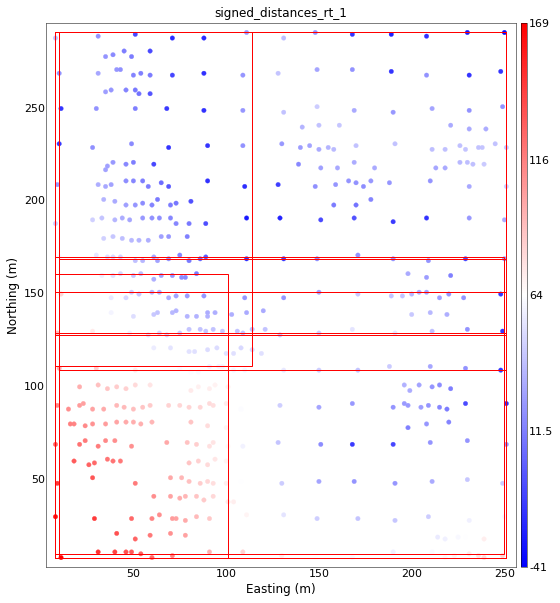

In [337]:
c=0
fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)
for u, l in zip(ups, lows):

    rect1 = Rectangle((l[0], l[1]), u[0]-l[0], u[1]-l[1], linewidth=1, edgecolor='red', facecolor='none')
    axs.add_patch(rect1)

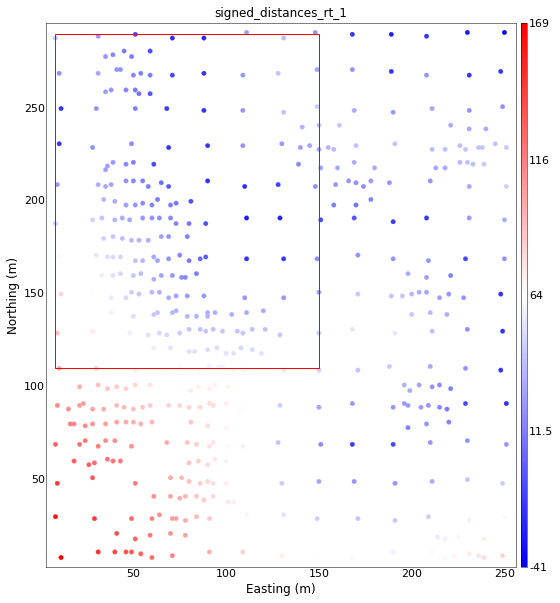

In [316]:
c=4
fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)
rect1 = Rectangle((lows[c][0], lows[c][1]), ups[c][0]-lows[c][0], ups[c][1]-lows[c][1], linewidth=1, edgecolor='red', facecolor='none')
axs.add_patch(rect1)

In [341]:
yobs = data['signed_distances_rt_1'].values

xflat = np.vstack((
    grid_coords[0],
    grid_coords[1],
    #grid_coords[2]
)).T

In [210]:
yflat = RBFInterpolator(xobs, yobs)(xflat)

In [11]:
interp = LinearNDInterpolator(xobs, yobs)
Z = interp(xflat)

In [12]:
def plot_contour(x,y,z,resolution = 50,contour_method='linear'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method)
    return X,Y,Z

In [13]:
Xrbf, Yrbf, Zrbf = plot_contour(grid_coords[0],grid_coords[1],yflat,resolution = 50,contour_method='linear')
Xlin, Ylin, Zlin = plot_contour(grid_coords[0],grid_coords[1],Z,resolution = 50,contour_method='linear')

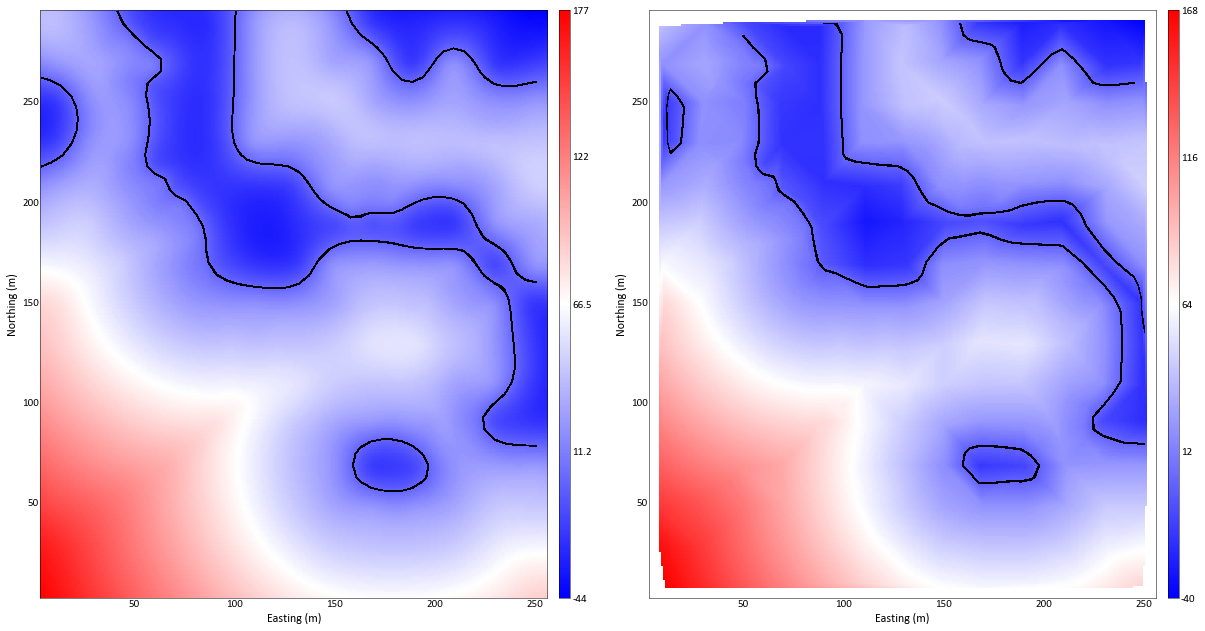

In [14]:
fig, axs = plt.subplots(1,2, figsize=(20,20))
_ = gs.slice_plot(yflat, griddef=grid, cmap='bwr', ax=axs[0])
axs[0].contourf(Xrbf,Yrbf,Zrbf, [0, 1], colors=['black'])
_= gs.slice_plot(Z, griddef=grid, cmap='bwr', ax=axs[1])
axs[1].contourf(Xlin,Ylin,Zlin, [0, 1], colors=['black'])
plt.savefig('both.png', facecolor='white', bbox_inches='tight')
plt.show()